In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cv2

In [3]:
# np_array_u = np.load("/content/3311.npy")
# np_array_l = np.load("/content/L3315.npy")

In [4]:
# np_array_u

In [5]:
# np_array_u.shape

In [6]:
# plt.imshow(np_array_u.reshape(409,-1))

In [7]:
path="/home/user/Documents/model_class/trimmed_waveform_1/content/drive/MyDrive/trimmed_waveform_1"

In [8]:
# plt.plot(np_array_u)
# plt.plot(np_array_l)

In [9]:
[200,409,1]

[200, 409, 1]

In [10]:
path = r"/home/user/Documents/model_class/trimmed_waveform_1/content/drive/MyDrive/trimmed_waveform_1"

In [11]:
binary_files = glob.glob(path + "/*.bin")


In [12]:
for file_path in binary_files:
    with open(file_path, "rb") as binary_file:
        content = binary_file.read()
        print(content)

In [13]:
unlensed_waveform = glob.glob(path+"/*.npy")

In [14]:
lensed_waveform = []  # Initialize lists to store filenames
unlensed_waveform = []

for i in glob.glob(path + "/L*.npy"):
    lensed_waveform.append(i)

for i in glob.glob(path + "/*.npy"):
    if not any(i == lwf for lwf in lensed_waveform):
        unlensed_waveform.append(i)



In [15]:
len(lensed_waveform)


10000

In [16]:
len(unlensed_waveform)

10000

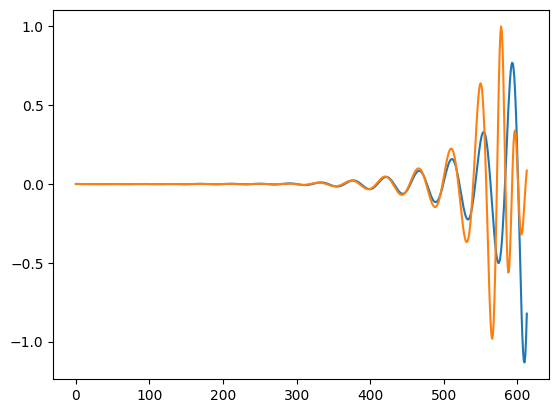

In [17]:
type(lensed_waveform)
plt.plot(np.load(lensed_waveform[9]))
plt.plot(np.load(unlensed_waveform[9]))


In [18]:
lensed_waveform = [np.load(file) for file in lensed_waveform]
unlensed_waveform = [np.load(file) for file in unlensed_waveform]

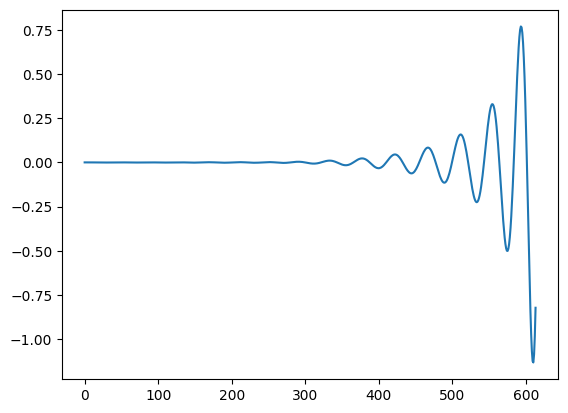

<Figure size 40900x100 with 0 Axes>

In [19]:
plt.plot(lensed_waveform[9])
plt.figure(figsize=(409, 1))
plt.savefig('plot.png')
plt.show()


In [20]:
desired_shape = (409, 1)
lensed_waveform = [np.resize(waveform, desired_shape) for waveform in lensed_waveform]
unlensed_waveform = [np.resize(waveform, desired_shape) for waveform in unlensed_waveform]

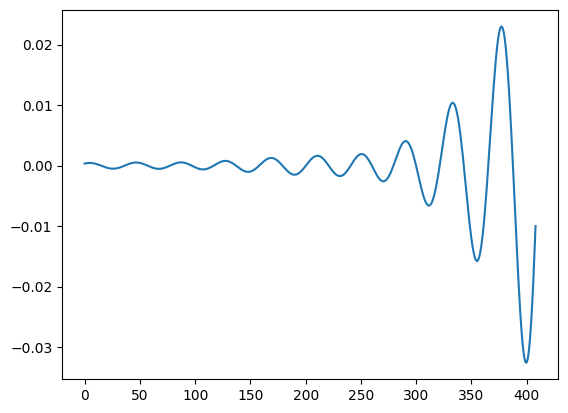

In [21]:
plt.plot(lensed_waveform[9])

In [22]:
(lensed_waveform[0].shape)

(409, 1)

In [23]:
# Created labels
lensed_labels = np.ones(len(lensed_waveform))
unlensed_labels = np.zeros(len(unlensed_waveform))


In [24]:
# Combine data and labels

from sklearn.model_selection import train_test_split
X = np.concatenate([lensed_waveform, unlensed_waveform])
y = np.concatenate([lensed_labels, unlensed_labels])

# Split data into training and testing sets
# from sklearn.model_selection import train_test_split

# Assuming your data is in X and y variables
# X represents the features, and y represents the target variable

# Split the data into training and testing sets (80% training, 20% test+validation)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the test+validation set into test and validation sets (50% test, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)


In [25]:
y_train.shape

(16000,)

In [26]:
y_val.shape
X_train.shape

(16000, 409, 1)

1.0


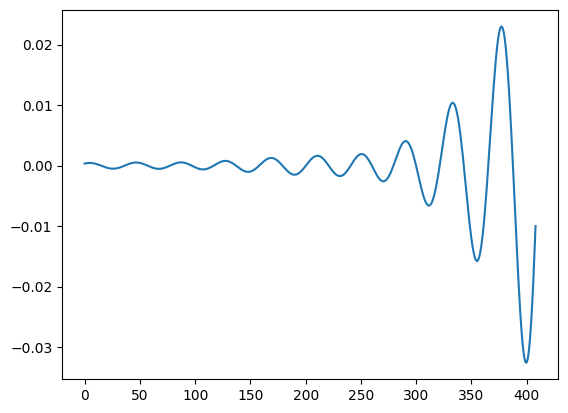

In [27]:
plt.plot(X[9])
print(y[9])

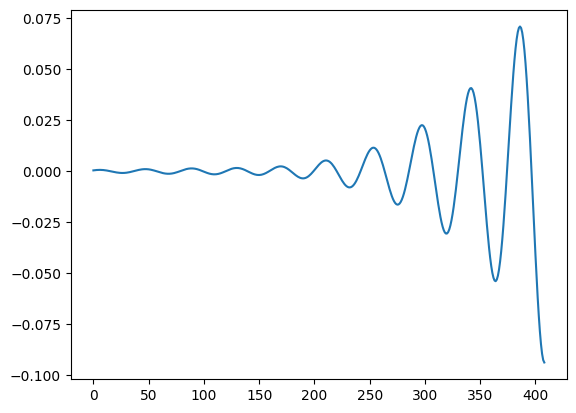

In [28]:
plt.plot(X_train[3])


In [29]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


2024-04-07 09:00:57.382749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 09:00:59.404398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [30]:
model = MobileNetV2(weights='imagenet', include_top=False)  # Load the pre-trained model without the top classification layers


/tmp/ipykernel_13017/3099244021.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights='imagenet', include_top=False)  # Load the pre-trained model without the top classification layers


In [31]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = models.Sequential()

model.add(layers.Input(shape=(409, 1)))

model.add(layers.Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv1D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

model.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Assuming X_test and y_test are defined somewhere earlier in your code
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.4819 - loss: 1.6267
Test accuracy: 0.49000000953674316


# **Test Accuracy: 80%**

In [32]:
from keras import models, layers
from keras.optimizers import SGD

# Assuming X_train, X_val, y_train, y_val, X_test, y_test are already defined

model = models.Sequential()
model.add(layers.Input(shape=(409, 1)))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7656,))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/10


2024-04-07 09:01:08.441310: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26176000 exceeds 10% of free system memory.
2024-04-07 09:01:11.686706: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19141632 exceeds 10% of free system memory.
2024-04-07 09:01:11.686924: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19141632 exceeds 10% of free system memory.
2024-04-07 09:01:11.699612: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18982912 exceeds 10% of free system memory.
2024-04-07 09:01:11.700588: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18982912 exceeds 10% of free system memory.


500/500 ━━━━━━━━━━━━━━━━━━━━ 293s 579ms/step - accuracy: 0.4942 - loss: 0.6931 - val_accuracy: 0.4820 - val_loss: 0.6932
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 307s 615ms/step - accuracy: 0.5114 - loss: 0.6931 - val_accuracy: 0.4805 - val_loss: 0.6932
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 327s 625ms/step - accuracy: 0.4983 - loss: 0.6931 - val_accuracy: 0.4805 - val_loss: 0.6932
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 343s 687ms/step - accuracy: 0.5029 - loss: 0.6931 - val_accuracy: 0.4805 - val_loss: 0.6932
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 369s 738ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.4805 - val_loss: 0.6932
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 297s 593ms/step - accuracy: 0.5100 - loss: 0.6931 - val_accuracy: 0.4805 - val_loss: 0.6932
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 348s 646ms/step - accuracy: 0.5013 - loss: 0.6931 - val_accuracy: 0.4805 - val_loss: 0.6932
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 434s 750ms/step - accuracy: 0.5033 - loss: 0.69

# **Test Accuracy: 88%**

In [33]:
from keras import models, layers
from keras.optimizers import Adam

# Assuming X_train, X_test, y_train, y_test are already defined

model = models.Sequential()
model.add(layers.Input(shape=(409, 1)))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7656,))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 374s 733ms/step - accuracy: 0.5038 - loss: 0.6929
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 282s 532ms/step - accuracy: 0.5537 - loss: 0.6892
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 366s 620ms/step - accuracy: 0.5480 - loss: 0.6874
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 297s 571ms/step - accuracy: 0.5612 - loss: 0.6848
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 296s 593ms/step - accuracy: 0.5636 - loss: 0.6828
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 297s 593ms/step - accuracy: 0.5681 - loss: 0.6803
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 335s 619ms/step - accuracy: 0.5694 - loss: 0.6788
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 305s 585ms/step - accuracy: 0.5743 - loss: 0.6735
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 306s 554ms/step - accuracy: 0.5885 - loss: 0.6706
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 359s 629ms/step - accuracy: 0.6018 - loss: 0.6662
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.5435 - loss: 0.6735
Test accuracy: 0.55150002

# **Test Accuracy: 91%**

In [34]:
#Test Accuracy: 91%

In [35]:
model = models.Sequential()
model.add(layers.Input(shape=(409, 1)))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7656,))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 616ms/step - accuracy: 0.5034 - loss: 0.6929
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 306s 611ms/step - accuracy: 0.5556 - loss: 0.6896
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 323s 614ms/step - accuracy: 0.5463 - loss: 0.6885
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 307s 584ms/step - accuracy: 0.5569 - loss: 0.6836
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 300s 601ms/step - accuracy: 0.5649 - loss: 0.6798
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 318s 592ms/step - accuracy: 0.5791 - loss: 0.6754
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 331s 610ms/step - accuracy: 0.5837 - loss: 0.6714
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 295s 591ms/step - accuracy: 0.5896 - loss: 0.6663
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 321s 589ms/step - accuracy: 0.6074 - loss: 0.6548
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 295s 590ms/step - accuracy: 0.6090 - loss: 0.6503
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 324s 593ms/step - accuracy: 0.6138 - loss: 0.6466
Epoch 12

In [36]:
model.save

<bound method Model.save of <Sequential name=sequential_3, built=True>>

## Accuracy:90%


In [37]:
model = models.Sequential()
model.add(layers.Input(shape=(409, 1)))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7656,))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 294s 574ms/step - accuracy: 0.5051 - loss: 0.6929
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 337s 605ms/step - accuracy: 0.5408 - loss: 0.6904
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 321s 604ms/step - accuracy: 0.5515 - loss: 0.6879
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 293s 586ms/step - accuracy: 0.5618 - loss: 0.6850
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 396s 734ms/step - accuracy: 0.5644 - loss: 0.6810
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 323s 616ms/step - accuracy: 0.5756 - loss: 0.6781
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 318s 609ms/step - accuracy: 0.5828 - loss: 0.6739
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 328s 621ms/step - accuracy: 0.5830 - loss: 0.6693
Epoch 9/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 409s 795ms/step - accuracy: 0.5903 - loss: 0.6637
Epoch 10/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 343s 598ms/step - accuracy: 0.6049 - loss: 0.6574
Epoch 11/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 290s 581ms/step - accuracy: 0.6016 - loss: 0.6553
Epoch 12

#Test Accuracy: 94.35%
#(using Validation)

In [38]:
from keras import models, layers
from keras.optimizers import SGD

# Assuming X_train, X_val, y_train, y_val, X_test, y_test are already defined

model = models.Sequential()
model.add(layers.Input(shape=(409, 1)))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7656,))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 334s 654ms/step - accuracy: 0.5170 - loss: 0.6927 - val_accuracy: 0.5685 - val_loss: 0.6892
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 423s 736ms/step - accuracy: 0.5476 - loss: 0.6905 - val_accuracy: 0.5640 - val_loss: 0.6871
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 312s 598ms/step - accuracy: 0.5490 - loss: 0.6874 - val_accuracy: 0.5625 - val_loss: 0.6830
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 312s 579ms/step - accuracy: 0.5591 - loss: 0.6851 - val_accuracy: 0.5825 - val_loss: 0.6788
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 352s 640ms/step - accuracy: 0.5679 - loss: 0.6824 - val_accuracy: 0.5870 - val_loss: 0.6719
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 333s 663ms/step - accuracy: 0.5665 - loss: 0.6755 - val_accuracy: 0.5855 - val_loss: 0.6645
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 394s 788ms/step - accuracy: 0.5814 - loss: 0.6689 - val_accuracy: 0.5935 - val_loss: 0.6615
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 1401s 3s/step - accuracy: 0.5955 - l

In [39]:
from keras import models, layers
from keras.optimizers import SGD

# Assuming X_train, X_val, y_train, y_val, X_test, y_test are already defined

model = models.Sequential()
model.add(layers.Input(shape=(409, 1)))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(7656,))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 330s 642ms/step - accuracy: 0.5109 - loss: 0.6928 - val_accuracy: 0.5530 - val_loss: 0.6893
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 313s 626ms/step - accuracy: 0.5432 - loss: 0.6899 - val_accuracy: 0.5635 - val_loss: 0.6855
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 304s 609ms/step - accuracy: 0.5522 - loss: 0.6869 - val_accuracy: 0.5620 - val_loss: 0.6834
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 296s 592ms/step - accuracy: 0.5504 - loss: 0.6873 - val_accuracy: 0.5755 - val_loss: 0.6798
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 304s 557ms/step - accuracy: 0.5547 - loss: 0.6844 - val_accuracy: 0.5810 - val_loss: 0.6793
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 317s 548ms/step - accuracy: 0.5601 - loss: 0.6825 - val_accuracy: 0.5660 - val_loss: 0.6763
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 319s 542ms/step - accuracy: 0.5659 - loss: 0.6792 - val_accuracy: 0.5725 - val_loss: 0.6746
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 317s 532ms/step - accuracy: 0.5665 -

In [41]:
y_train.shape

(16000,)

In [ ]:
plt.plot(l_arrays[0], label="lensed", color="blue")
plt.plot(u_arrays[0],label="unlensed", color="red")
plt.xlabel("Time")
plt.ylabel("Strain")
plt.legend()